In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import pandas_profiling as pdp

% matplotlib inline

In [3]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [4]:
sampleSubmission = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/sampleSubmission.csv')
spray = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/spray.csv')
test = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/test.csv')
train = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/train.csv')
weather = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/weather.csv')
print('sampleSubmission.shape:', sampleSubmission.shape)
print('spray.shape:', spray.shape)
print('test.shape:', test.shape)
print('train.shape:', train.shape)
print('weather.shape:', weather.shape)

sampleSubmission.shape: (116293, 2)
spray.shape: (14835, 4)
test.shape: (116293, 11)
train.shape: (10506, 12)
weather.shape: (2944, 22)


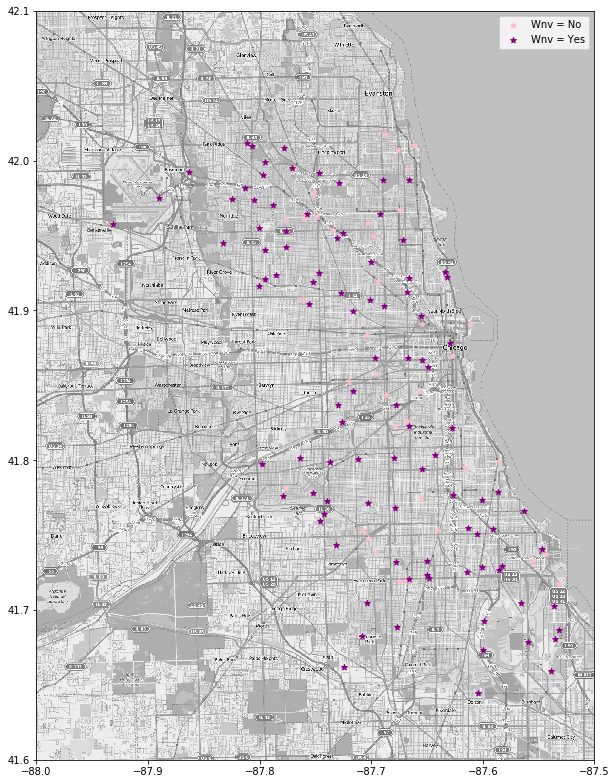

In [5]:
mapdata = np.loadtxt("c:/Users/ghafo/west_nile_virus/assets/input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('c:/Users/ghafo/west_nile_virus/assets/input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

traps1 = traps[traps.WnvPresent==1]
traps0 = traps[traps.WnvPresent==0]

traps1 = traps1[['Longitude', 'Latitude']].drop_duplicates().values
traps0 = traps0[['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(traps0[:,0], traps0[:,1], color='pink', marker='*', alpha=1, label='Wnv = No');
plt.scatter(traps1[:,0], traps1[:,1], color='purple', marker='*', alpha=1, label='Wnv = Yes');
plt.legend();

plt.savefig('trap_map.png');

In [6]:
# Date
train['Date'] = pd.to_datetime(train['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])

In [7]:
# Duplicates
train.drop(train[train.duplicated(keep='first')].index,axis=0,inplace=True)
spray.drop(spray[spray.duplicated(keep='first')].index,axis=0,inplace=True)

In [8]:
mosq = [col for col in train.columns if 'Species_' in col]

In [9]:
# Weather Data
def rainy_day(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float) # and everything else into a float

In [10]:
for col in ['Tavg','PrecipTotal','Depart','WetBulb','SnowFall',
            'StnPressure','SeaLevel','Depth','AvgSpeed','Heat','Cool']:
    rainy_day(col)

In [11]:
weather['Tavg'][weather.Tavg==0] = (weather['Tmin'] + weather['Tmax']) / 2

C:\Users\ghafo\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
# Numeric
cols = [col for col in weather.columns if col not in ('Station','Date')]

bad_col = []

for col in cols:
    try:
        weather[col] = pd.to_numeric(weather[col])
    except:
        bad_col.append(col)
print(bad_col)

['Sunrise', 'Sunset', 'CodeSum', 'Water1']


In [13]:
weather.drop('CodeSum',axis=1,inplace=True)
bad_col.remove('CodeSum')

In [14]:
bad_data = {}

for col in bad_col:
    z = []
    for i in weather[col]:
        try:
            pd.to_numeric(i)
        except:
            if i in z:
                pass
            else:
                z.append(i)
    bad_data[col] = z
bad_data

{'Sunrise': ['-'], 'Sunset': ['-'], 'Water1': ['M']}

In [16]:
weather.drop(bad_col,axis=1,inplace=True)

In [17]:
print(train.duplicated(['Date','Species','Trap']).sum())

train[train.duplicated(['Date','Species','Trap'],keep=False)].sort_values(['Date','Trap','Species'])['WnvPresent'].value_counts()

1218


0    1727
1     193
Name: WnvPresent, dtype: int64

In [18]:
train['WnvPresent'].value_counts(())

0    9190
1     503
Name: WnvPresent, dtype: int64

In [19]:
train = train.groupby(['Date','Address','Species','Block','Street',
              'Trap','AddressNumberAndStreet','Latitude','Longitude','AddressAccuracy']).sum().reset_index()
train['WnvPresent'] = train['WnvPresent'].map(lambda x: 1 if x >= 1 else 0)
train['WnvPresent'].value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

In [20]:
# day
train["dayofyear"] = train['Date'].dt.dayofyear

# week
train['week'] = train['Date'].dt.week

# month
train['month'] = train['Date'].dt.month

# quarter
train['quarter'] = train['Date'].dt.quarter

In [21]:
# get dummies for mosquito species

train = pd.get_dummies(train, columns=['Species'])

### Join Weather Data to Trap Data

In [22]:
print(len(train),len(weather))

8475 2944


In [23]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Depth', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [24]:
station1 = weather[weather['Station']==1].copy()
station2 = weather[weather['Station']==2].copy()


#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
station1['Latitude'] = 41.995
station1['Longitude'] = -87.9336

#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station2['Latitude'] = 41.78611
station2['Longitude'] = -87.75222

In [25]:
stations = pd.merge(station1,station2,on='Date',suffixes=('_s1','_s2'))
traps_weather = pd.merge(train,stations,on='Date')

### Calculate point estimates of weather data at trap location

In [26]:
# calculate distance of traps to weather stations
dist_1 = np.sqrt(((traps_weather['Latitude'] - traps_weather['Latitude_s1'])**2 + 
 (traps_weather['Longitude'] - traps_weather['Longitude_s1'])**2))

dist_2 = np.sqrt(((traps_weather['Latitude'] - traps_weather['Latitude_s2'])**2 + 
 (traps_weather['Longitude'] - traps_weather['Longitude_s2'])**2))

# calculate distance weights to each trap
# to weight the weather data by proximity
total_dist = dist_1 + dist_2
traps_weather['weight_1'] = dist_1 / total_dist
traps_weather['weight_2'] = dist_2 / total_dist

In [27]:
# Apply distance weights to weather data
# Inverse weight because the closer station should have the heavier weight

station1_list = [col for col in traps_weather.columns 
                if '_s1' in col and col not in ('Station_s1','Latitude_s1','Longitude_s1')]
station2_list = [col for col in traps_weather.columns 
                 if '_s2' in col and col not in ('Station_s2','Latitude_s2','Longitude_s2')]

for col in station1_list:
    traps_weather[col] = traps_weather['weight_2'] * traps_weather[col]
for col in station2_list:
    traps_weather[col] = traps_weather['weight_1'] * traps_weather[col]

In [28]:
traps_weather.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'dayofyear', 'week', 'month', 'quarter',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Station_s1', 'Tmax_s1', 'Tmin_s1',
       'Tavg_s1', 'Depart_s1', 'DewPoint_s1', 'WetBulb_s1', 'Heat_s1',
       'Cool_s1', 'Depth_s1', 'SnowFall_s1', 'PrecipTotal_s1',
       'StnPressure_s1', 'SeaLevel_s1', 'ResultSpeed_s1', 'ResultDir_s1',
       'AvgSpeed_s1', 'Latitude_s1', 'Longitude_s1', 'Station_s2', 'Tmax_s2',
       'Tmin_s2', 'Tavg_s2', 'Depart_s2', 'DewPoint_s2', 'WetBulb_s2',
       'Heat_s2', 'Cool_s2', 'Depth_s2', 'SnowFall_s2', 'PrecipTotal_s2',
       'StnPressure_s2', 'SeaLevel_s2', 'ResultSpeed_s2', 'ResultDir_s2',
       'AvgSpeed_s2', 'Latitud

In [29]:
for col in [col for col in traps_weather.columns 
            if 's1' in col and col not in ('Station_s1','Latitude_s1','Longitude_s1')]:
    name = col.replace('_s1','')
    traps_weather[name] = traps_weather[col] + traps_weather[name+'_s2']
    traps_weather.drop([col,name+'_s2'],axis=1,inplace=True)

In [30]:
traps_weather.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'dayofyear', 'week', 'month', 'quarter',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Station_s1', 'Latitude_s1', 'Longitude_s1',
       'Station_s2', 'Latitude_s2', 'Longitude_s2', 'weight_1', 'weight_2',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [31]:
# Drop station information columns
col1 = [col for col in traps_weather.columns if '_s1' in col]
col2 = [col for col in traps_weather.columns if '_s2' in col]
cols = col1 + col2

traps_weather.drop(cols,axis=1,inplace=True)

### Spraying Data

In [32]:
len(spray)

14294

In [85]:
spray.head(3)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [33]:
distance = []
time = []

for i in traps_weather.index:
    temp_lat = traps_weather.at[i,'Latitude']
    temp_long = traps_weather.at[i,'Longitude']

    # calculate distance from traps to spray locations
    dist = np.sqrt((spray['Latitude'] - temp_lat)**2 + (spray['Longitude'] - temp_long)**2)
    distance.append(dist)

    # calculate time since spray
    time_since_spray = traps_weather.at[i,'Date'] - spray['Date']
    time_since_spray = time_since_spray.dt.total_seconds()
    time_since_spray = (((time_since_spray/60)/60)/24)
    time.append(time_since_spray)

distance = pd.DataFrame(distance)
time = pd.DataFrame(time)

time.reset_index(inplace=True)
time.drop('index',axis=1,inplace=True)

backup = time.copy()

In [34]:
for col in time.columns:
    time[col] = time[col].map(lambda x: 0 if x < 0 else x)

In [35]:
distance.head()

,0,1,2,3,4,5,6,7,8,9,...,14825,14826,14827,14828,14829,14830,14831,14832,14833,14834
0,0.681387,0.681176,0.680920,0.680625,0.680259,0.679900,0.679914,0.680187,0.680478,0.680715,...,0.212910,0.212530,0.212131,0.211709,0.211261,0.210855,0.213356,0.214291,0.213947,0.213557
1,0.681387,0.681176,0.680920,0.680625,0.680259,0.679900,0.679914,0.680187,0.680478,0.680715,...,0.212910,0.212530,0.212131,0.211709,0.211261,0.210855,0.213356,0.214291,0.213947,0.213557
2,0.688519,0.688308,0.688052,0.687758,0.687392,0.687032,0.687046,0.687318,0.687609,0.687846,...,0.220119,0.219739,0.219340,0.218917,0.218469,0.218063,0.220563,0.221497,0.221153,0.220762
3,0.658528,0.658321,0.658071,0.657783,0.657415,0.657045,0.657048,0.657314,0.657599,0.657831,...,0.193764,0.193432,0.193087,0.192715,0.192326,0.191976,0.194760,0.195802,0.195511,0.195180
4,0.584809,0.584581,0.584307,0.583989,0.583633,0.583316,0.583370,0.583663,0.583976,0.584232,...,0.114286,0.113778,0.113236,0.112683,0.112081,0.111528,0.112919,0.113450,0.112973,0.112431


In [36]:
time.head()

,0,1,2,3,4,5,6,7,8,9,...,14825,14826,14827,14828,14829,14830,14831,14832,14833,14834
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Define data day and data week to run a seperate model

spray_data = [time[i] * distance[i] for i in time.columns]
spray_data = pd.DataFrame(spray_data).transpose()

dataDay = pd.merge(traps_weather,spray_data,how='inner',left_index=True,right_index=True)
dataWeek = pd.merge(traps_weather,spray_data,how='inner',left_index=True,right_index=True)
print(dataDay.shape)
print(dataWeek.shape)

(8475, 14334)
(8475, 14334)


### Train/Test/Split

In [43]:
dataDay.columns[0:15] # take a look at last 4 features

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'dayofyear', 'week', 'month', 'quarter'],
      dtype='object')

In [44]:
dataWeek.columns[0:15] # take a look at last 4 features

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'dayofyear', 'week', 'month', 'quarter'],
      dtype='object')

In [45]:
dataDay.drop(['Address','Block','Street','Trap',
           'AddressNumberAndStreet','Latitude','Longitude','AddressAccuracy','weight_1',
          'weight_2','Date','NumMosquitos', 'week', 'quarter', 'month'],axis=1,inplace=True)
# Keep dayofyear and remove week, month, quarter

In [46]:
dataWeek.drop(['Address','Block','Street','Trap',
           'AddressNumberAndStreet','Latitude','Longitude','AddressAccuracy','weight_1',
          'weight_2','Date','NumMosquitos', 'dayofyear', 'quarter', 'month'],axis=1,inplace=True)
# Keep week and remove dayofyear, month, quarter

In [47]:
from sklearn.model_selection import train_test_split

XDay = dataDay.drop('WnvPresent', 1)
yDay = dataDay['WnvPresent']

XDay_train, XDay_test, yDay_train, yDay_test = train_test_split(XDay, yDay, test_size=0.5, random_state=42)
print(XDay.shape, yDay.shape)                                                                                      
print(XDay_train.shape, yDay_train.shape)
print(XDay_test.shape, yDay_test.shape)

(8475, 14318) (8475,)
(4237, 14318) (4237,)
(4238, 14318) (4238,)


In [48]:
XWeek = dataWeek.drop('WnvPresent', 1)
yWeek = dataWeek['WnvPresent']

XWeek_train, XWeek_test, yWeek_train, yWeek_test = train_test_split(XWeek, yWeek, test_size=0.5, random_state=42)
print(XWeek.shape, yWeek.shape)                                                                                      
print(XWeek_train.shape, yWeek_train.shape)
print(XWeek_test.shape, yWeek_test.shape)

(8475, 14318) (8475,)
(4237, 14318) (4237,)
(4238, 14318) (4238,)


In [49]:
XnsDay = dataDay.drop('WnvPresent',axis=1)
XnsDay = XnsDay[['dayofyear',        'Species_CULEX ERRATICUS',
                'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
               'Species_CULEX RESTUANS',       'Species_CULEX SALINARIUS',
               'Species_CULEX TARSALIS',        'Species_CULEX TERRITANS',
                                 'Tmax',                           'Tmin',
                                 'Tavg',                         'Depart',
                             'DewPoint',                        'WetBulb',
                                 'Heat',                           'Cool',
                                'Depth',                       'SnowFall',
                          'PrecipTotal',                    'StnPressure',
                             'SeaLevel',                    'ResultSpeed',
                            'ResultDir',                       'AvgSpeed',]]
ynsDay = dataDay['WnvPresent']

XnsDay_train,XnsDay_test,ynsDay_train,ynsDay_test = train_test_split(XnsDay,ynsDay,
                                                                     test_size=0.5,random_state=42)

In [50]:
XnsWeek = dataWeek.drop('WnvPresent',axis=1)
XnsWeek = XnsWeek[['week',        'Species_CULEX ERRATICUS',
                'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
               'Species_CULEX RESTUANS',       'Species_CULEX SALINARIUS',
               'Species_CULEX TARSALIS',        'Species_CULEX TERRITANS',
                                 'Tmax',                           'Tmin',
                                 'Tavg',                         'Depart',
                             'DewPoint',                        'WetBulb',
                                 'Heat',                           'Cool',
                                'Depth',                       'SnowFall',
                          'PrecipTotal',                    'StnPressure',
                             'SeaLevel',                    'ResultSpeed',
                            'ResultDir',                       'AvgSpeed',]]
ynsWeek = dataWeek['WnvPresent']

XnsWeek_train,XnsWeek_test,ynsWeek_train,ynsWeek_test = train_test_split(XnsWeek,ynsWeek,
                                                                     test_size=0.5,random_state=42)

## Modeling

In [51]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

### Random Forest (No Spray) - Week

In [52]:
rfcWeek = RandomForestClassifier(n_estimators=100,class_weight='balanced_subsample',
                             random_state=42,n_jobs=-1,verbose=1)
print('Cross-validating...')
rfcWeek_scores = cross_val_score(rfcWeek,XnsWeek_train,ynsWeek_train,
                             cv=3,n_jobs=-1,verbose=1)
print(rfcWeek_scores)
print('cross val score: {}'.format(np.mean(rfcWeek_scores)))

print('Fitting...')
rfcWeek = rfcWeek.fit(XnsWeek_train,ynsWeek_train)

rfcWeek_preds = rfcWeek.predict(XnsWeek_test)

tnWeek, fpWeek, fnWeek, tpWeek = confusion_matrix(ynsWeek_test,rfcWeek_preds).ravel()
print('tnWeek,fpWeek,fnWeek,tpWeek')
print(tnWeek,fpWeek,fnWeek,tpWeek)

print('accuracy score: {}'.format(accuracy_score(ynsWeek_test, rfcWeek_preds)))
print('precision score: {}'.format(precision_score(ynsWeek_test,rfcWeek_preds)))
print('recall score: {}'.format(accuracy_score(ynsWeek_test,rfcWeek_preds)))
print(classification_report(ynsWeek_test,rfcWeek_preds))

Cross-validating...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.7s finished


[ 0.92639774  0.93205945  0.92416726]
cross val score: 0.927541480187433
Fitting...


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s


tnWeek,fpWeek,fnWeek,tpWeek
3908 103 192 35
accuracy score: 0.9303916941953752
precision score: 0.2536231884057971
recall score: 0.9303916941953752
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      4011
          1       0.25      0.15      0.19       227

avg / total       0.92      0.93      0.92      4238



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


### Support Vector Machine (No Spray) - Week


In [53]:
print('GridSearching...')
svmWeek_params = {'kernel':['linear','rbf','sigmoid']}

svmWeek = SVC(kernel='kernel',class_weight='balanced',
          verbose=1,random_state=42,probability=True)
svmWeek_gscv = GridSearchCV(svmWeek,svmWeek_params,
                        n_jobs=-1,verbose=1,cv=3)
print('Fitting...')
svmWeek_gscv.fit(XnsWeek_train,ynsWeek_train)

print('Scoring...')
svmWeek_scores = svmWeek_gscv.score(XnsWeek_train,ynsWeek_train)

print(svmWeek_scores)
print('accuracy score: {}'.format(np.mean(svmWeek_scores)))

svmWeek_preds = svmWeek_gscv.best_estimator_.predict(XnsWeek_test)
svmWeek_probas = svmWeek_gscv.best_estimator_.predict_proba(XnsWeek_test)

tnWeek, fpWeek, fnWeek, tpWeek = confusion_matrix(ynsWeek_test,svmWeek_preds).ravel()
print('tnWeek,fpWeek,fnWeek,tpWeek')
print(tnWeek,fpWeek,fnWeek,tpWeek)

print('accuracy score: {}'.format(accuracy_score(ynsWeek_test, svmWeek_preds)))
print('precision score: {}'.format(precision_score(ynsWeek_test,svmWeek_preds)))
print('recall score: {}'.format(accuracy_score(ynsWeek_test,svmWeek_preds)))
print(classification_report(ynsWeek_test,svmWeek_preds))

GridSearching...
Fitting...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   43.7s finished


[LibSVM]Scoring...
0.750059004012
accuracy score: 0.7500590040122729
tnWeek,fpWeek,fnWeek,tpWeek
2946 1065 42 185
accuracy score: 0.738791882963662
precision score: 0.148
recall score: 0.738791882963662
             precision    recall  f1-score   support

          0       0.99      0.73      0.84      4011
          1       0.15      0.81      0.25       227

avg / total       0.94      0.74      0.81      4238



In [54]:
svmWeek_gscv.best_estimator_

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=1)

In [55]:
svmWeek_probas

array([[ 0.93354714,  0.06645286],
       [ 0.93150451,  0.06849549],
       [ 0.98349141,  0.01650859],
       ..., 
       [ 0.98941055,  0.01058945],
       [ 0.96988962,  0.03011038],
       [ 0.96490281,  0.03509719]])

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ynsWeek_test,svmWeek_probas[:,1])

0.80570611435293027

In [58]:
svmWeek_gscv.best_estimator_.dual_coef_

array([[-0.52869978, -0.14401061, -0.52869978, ...,  9.21086957,
         1.41021517,  9.21086957]])